In [1]:
from exp.expdata import LotkaVolterraExp
import matplotlib.pyplot as plt

In [2]:
noise=0.5
noise = 0.1
dt_train = 5.1
t1=97.
t1=46.
t1=103.
expdata = LotkaVolterraExp(t0=0.,t1=t1,noise=noise, dt_train=dt_train,n_colloc=500, feature_names=['x','y'])

In [3]:
x_true = expdata.x_true
t_true = expdata.t_true

t_train = expdata.t_train
x_train = expdata.x_train

In [4]:
t_train[-1]+dt_train, t_train

(Array(107.1, dtype=float64),
 Array([  0. ,   5.1,  10.2,  15.3,  20.4,  25.5,  30.6,  35.7,  40.8,
         45.9,  51. ,  56.1,  61.2,  66.3,  71.4,  76.5,  81.6,  86.7,
         91.8,  96.9, 102. ], dtype=float64))

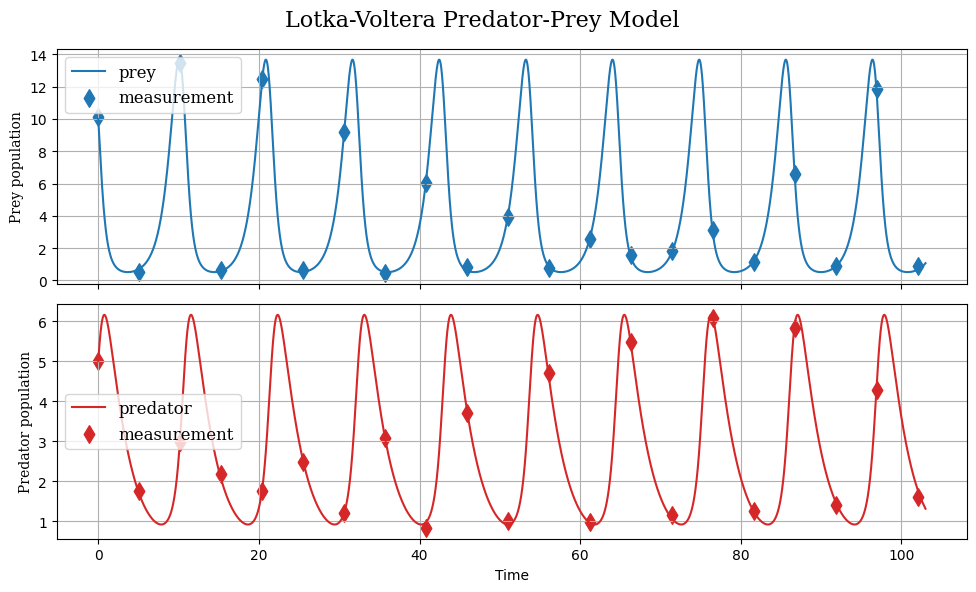

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,6), sharex=True)

fontname = 'serif'

ax1.plot(t_true, x_true[:,0], label="prey", c='tab:blue',)
ax1.scatter(t_train, x_train[:,0], label="measurement", marker='d',s=80)
ax1.set_ylabel("Prey population", fontname=fontname)
ax1.legend(prop={'family': fontname, 'size':12})
ax1.grid(True)

ax2.plot(t_true, x_true[:,1], label='predator', c='tab:red')
ax2.scatter(t_train, x_train[:,1], label="measurement", c='tab:red', marker='d',s=80)
ax2.set_ylabel("Predator population", fontname=fontname)
ax2.set_xlabel("Time")
ax2.grid(True)
ax2.legend(prop={'family': fontname, 'size':12})

plt.suptitle("Lotka-Voltera Predator-Prey Model", fontsize=16, fontname=fontname)
plt.tight_layout()
plt.show()

$$\dot x = \alpha x - \beta x y$$
$$\dot y = -\gamma y + \delta x y $$

where $\alpha = 1.1$, $\beta = 0.4$, $\gamma  = 0.4$, and $\delta = 0.1$.

In [6]:
expdata.print(precision=1)

(x)' = 1.1 x + -0.4 x y
(y)' = -0.4 y + 0.1 x y


Estimated dominant frequency: 0.097 Hz
Nyquist sampling frequency: 0.194 Hz
Sampling rate: 5.150 s


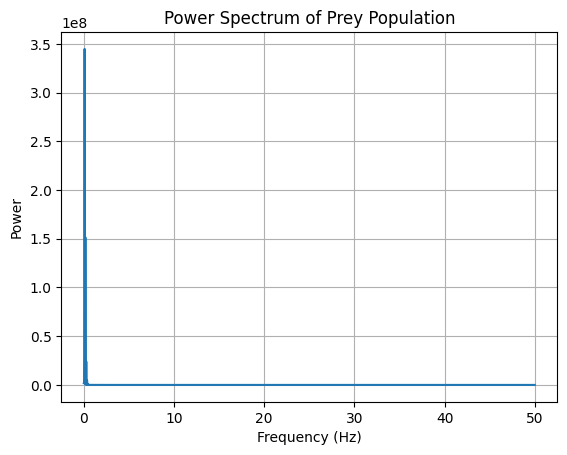

In [7]:
from scipy.fft import fft, fftfreq
import numpy as np
import matplotlib.pyplot as plt

# Assuming `sol` from earlier
prey = x_true[:,0]
t = t_true
dt = t[1] - t[0]

# Perform FFT
Y = fft(prey - np.mean(prey))  # Remove DC component
freqs = fftfreq(len(t), dt)

# Only positive frequencies
pos_mask = freqs > 0
pos_freqs = freqs[pos_mask]
power = np.abs(Y[pos_mask])**2

# Find peak frequency
f_max = pos_freqs[np.argmax(power)]
nyquist_fs = 2 * f_max

print(f"Estimated dominant frequency: {f_max:.3f} Hz")
print(f"Nyquist sampling frequency: {nyquist_fs:.3f} Hz")
print(f"Sampling rate: {1/nyquist_fs:.3f} s")

# Optional: Plot spectrum
plt.plot(pos_freqs, power)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectrum of Prey Population")
plt.grid(True)
plt.show()


# Learn Model

In [8]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import jax
jax.config.update('jax_enable_x64',True)

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import CholDataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel, PolyLib
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings
from jsindy.optim.solvers.alt_active_set_lm_solver import pySindySparsifier
from pysindy import STLSQ
from jsindy.kernels import ConstantKernel, ScalarMaternKernel


In [9]:

kernel = (
    ConstantKernel(variance = 5.)
    +ScalarMaternKernel(p = 5,variance = 10., lengthscale=3,min_lengthscale=0.05)
)   
kernel=None

trajectory_model = CholDataAdaptedRKHSInterpolant(kernel=kernel)
dynamics_model = FeatureLinearModel(
    reg_scaling = 1.,
    feature_map=PolyLib(degree=2)
    
)
optsettings = LMSettings(
    max_iter = 2000,
    atol_gradnorm=1e-8,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
data_weight = 20.
colloc_weight = 10.
sparsifier = pySindySparsifier(STLSQ(threshold = 0.05,alpha = 0.01))
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.1,
        solver_settings=optsettings,
        fixed_colloc_weight=colloc_weight,
        fixed_data_weight=data_weight,
        sparsifier = sparsifier
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=['x','y']
)

In [10]:
from exp.evaluate.jsindy import evaluate_jmodel

In [11]:
metrics = evaluate_jmodel(model=model,expdata=expdata)
model.print()
metrics['xdot_metrics']

  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(0.81166759, dtype=float64), 'data_weight': 20.0, 'colloc_weight': 10.0}
Warm Start


  0%|          | 0/2000 [00:00<?, ?it/s]

Iteration 0, loss = 1.036e+04, gradnorm = 1.234e+04, alpha = 16.88, improvement_ratio = 0.5758
Iteration 1, loss = 4.463e+03, gradnorm = 1.223e+05, alpha = 16.88, improvement_ratio = 0.5939
Iteration 2, loss = 2.43e+03, gradnorm = 6.762e+04, alpha = 16.88, improvement_ratio = 0.4908
Iteration 3, loss = 607.4, gradnorm = 6.446e+04, alpha = 16.88, improvement_ratio = 0.7756
Iteration 4, loss = 107.1, gradnorm = 8.76e+03, alpha = 14.06, improvement_ratio = 0.9397
Iteration 5, loss = 44.18, gradnorm = 1.313e+04, alpha = 14.06, improvement_ratio = 0.7537
Iteration 100, loss = 10.8, gradnorm = 3.495e-07, alpha = 69.44, improvement_ratio = 16.0
Model after smooth warm start
(x)' = 0.172 1 + 0.789 x + 0.018 y + 0.007 x^2 + -0.325 x y + -0.008 y^2
(y)' = -0.645 1 + 0.102 x + -0.066 y + -0.005 x^2 + 0.120 x y + -0.046 y^2
Alternating Activeset Sparsifier
6 active coeffs changed
Active set stabilized
Line search Failed
(x)' = 1.028 x + -0.368 x y
(y)' = -0.425 y + 0.113 x y


{'mse': Array(0.06123074, dtype=float64),
 'rmse': np.float64(0.24744845990795822),
 'mae': np.float64(0.14747016318176095),
 'max_abs_error': np.float64(0.8987499155229717),
 'normalized_mse': Array(0.0088066, dtype=float64),
 'relative_l2_error': np.float64(0.0938180088948603)}

In [12]:
expdata.print()

(x)' = 1.100 x + -0.400 x y
(y)' = -0.400 y + 0.100 x y


In [13]:
pred_sim = model.predict_state(expdata.t_true)
x_true = expdata.x_true

In [14]:
t_true.shape,t

((10300,),
 Array([0.0000e+00, 1.0000e-02, 2.0000e-02, ..., 1.0297e+02, 1.0298e+02,
        1.0299e+02], dtype=float64))

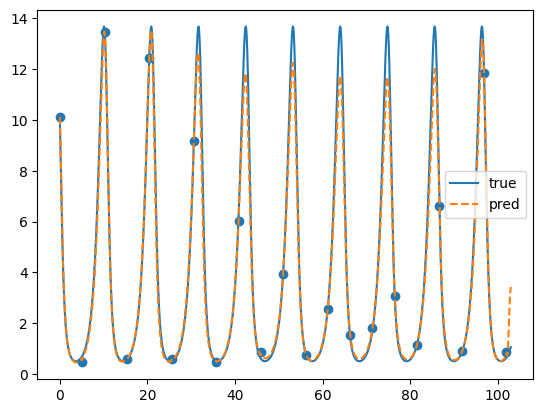

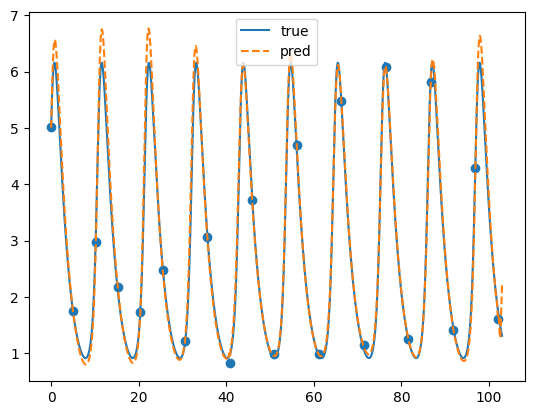

In [15]:
for i in range(len(pred_sim.T)):
    plt.scatter(t_train, x_train[:,i])
    plt.plot(t_true, x_true[:,i], label='true')
    # plt.plot(t_true, true[:,i])
    plt.plot(t_true, pred_sim[:,i], label='pred', linestyle='--')
    plt.legend()
    plt.show()

In [16]:
pred_sim = model.predict(expdata.x_true)
xdot_true = expdata.x_dot

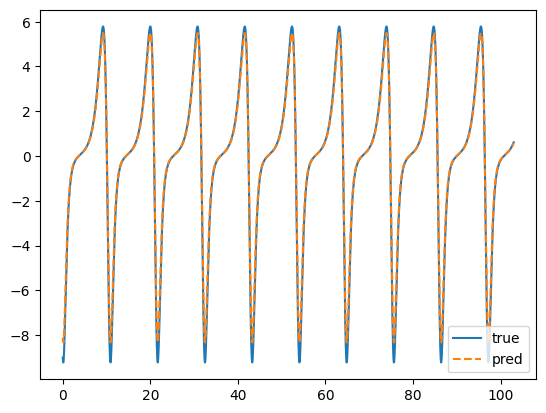

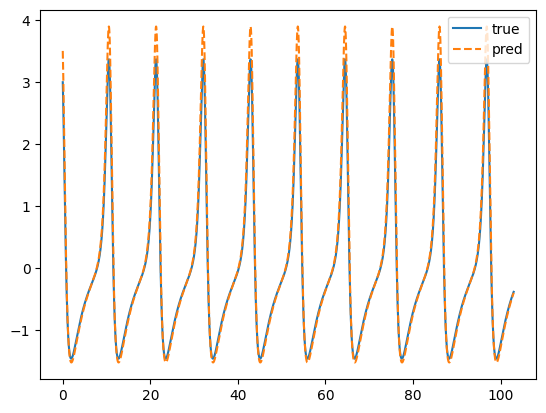

In [17]:
for i in range(len(pred_sim.T)):
    plt.plot(t_true, xdot_true[:,i], label='true')
    plt.plot(t_true, pred_sim[:,i], label='pred', linestyle='--')
    plt.legend()
    plt.show()

In [18]:
import jax
from equinox import tree_pprint
tree_pprint(model.traj_model.kernel, short_arrays=False)
k1 = model.traj_model.kernel.kernels[1]


SumKernel(
  kernels=(
    ConstantKernel(raw_variance=Array(12.41145808, dtype=float64)),
    ScalarMaternKernel(
      core_matern=<function build_matern_core.<locals>.<lambda>>,
      raw_variance=Array(10.90986589, dtype=float64),
      raw_lengthscale=Array(-0.77299785, dtype=float64),
      min_lengthscale=0.01
    )
  )
)


In [19]:
jax.nn.softplus(k1.raw_lengthscale) + k1.min_lengthscale


Array(0.38955027, dtype=float64)

# Test predict on test data.

# E-SINDy

In [20]:
import pysindy as ps